In [8]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)


import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_columns = 39

python 3.8.10 (default, Mar 18 2025, 20:04:55) 
[GCC 9.4.0]
numpy 1.19.5
pandas 1.2.5


In [9]:
sensor_data = pd.read_csv('Data/zkwgkjkjn9-2/Gas Sensors Measurements/Gas_Sensors_Measurements.csv',sep=',')

In [4]:
sensor_data.shape

(6400, 10)

In [14]:
sensor_data['Gas']

0         NoGas
1         NoGas
2         NoGas
3         NoGas
4         NoGas
         ...   
6395    Mixture
6396    Mixture
6397    Mixture
6398    Mixture
6399    Mixture
Name: Gas, Length: 6400, dtype: object

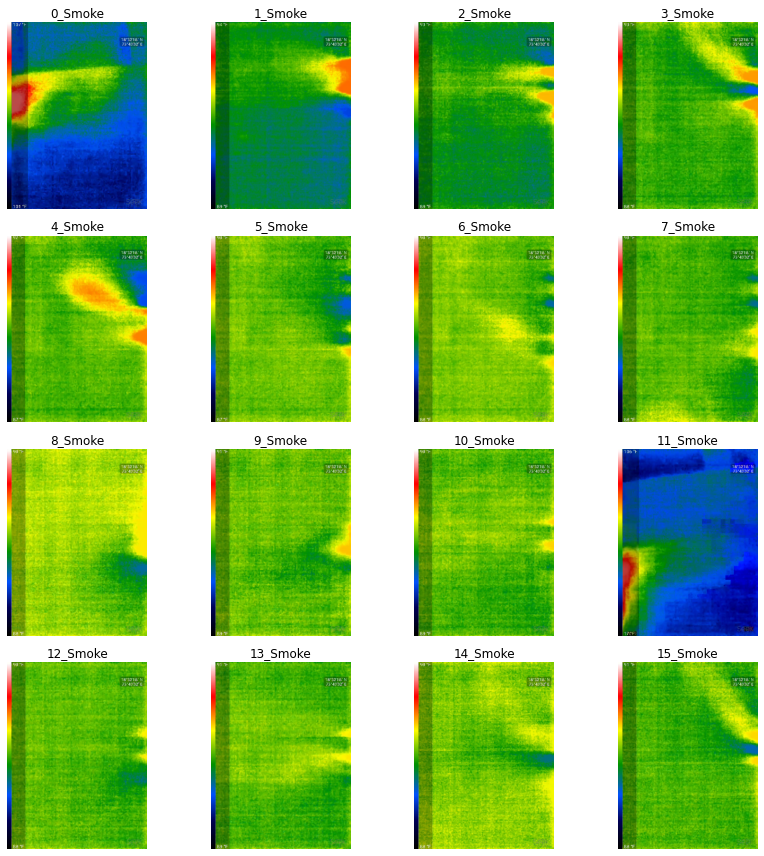

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import os

warnings.filterwarnings("ignore", category=UserWarning)



base_path = 'Data/zkwgkjkjn9-2/Thermal Camera Images/Smoke/'
file_template = '{}_Smoke.png'  

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(16):
    row = i // 4
    col = i % 4
    file_path = os.path.join(base_path, file_template.format(i))
    

    img = mpimg.imread(file_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"{i}_Smoke")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [2]:
import matplotlib.pyplot as plt

img = plt.imread('Data/zkwgkjkjn9-2/Thermal Camera Images/Smoke/0_Smoke.png')

print(type(img))      # <class 'numpy.ndarray'>
print(img.shape)      # (높이, 너비, 채널수)


<class 'numpy.ndarray'>
(640, 480, 3)


In [5]:
import numpy as np
from PIL import Image
import os

def save_vertical_stripe_heatmap(sensor_values, save_path, filename='heatmap_stripes.png'):
    """
    sensor_values: 7개 센서값 (예: [615, 339, 396, 412, 574, 598, 312])
    각 센서값을 세로 방향으로 stripe처럼 배치하여 224x224 heatmap 생성
    """
    assert len(sensor_values) == 7, "센서 값은 정확히 7개여야 합니다."

    width = 224
    height = 224
    stripe_width = width // 7  


    norm_vals = np.interp(sensor_values, (min(sensor_values), max(sensor_values)), (0, 255)).astype(np.uint8)


    img_array = np.zeros((height, width), dtype=np.uint8)

    for i, val in enumerate(norm_vals):
        start = i * stripe_width
        end = (i + 1) * stripe_width if i < 6 else width  
        img_array[:, start:end] = val


    img_rgb = np.stack([img_array]*3, axis=2)

    os.makedirs(save_path, exist_ok=True)
    img = Image.fromarray(img_rgb)
    img.save(os.path.join(save_path, filename))


    
sensor = [615, 339, 396, 412, 574, 598, 312]
save_vertical_stripe_heatmap(sensor, save_path='stripe_heatmaps', filename='smoke_stripe_224.png')


In [18]:
Nogas = sensor_data[sensor_data['Gas']=='NoGas']
for i in range(1600):
    sensor = Nogas.iloc[i,1:8]
    save_vertical_stripe_heatmap(sensor, save_path='Nogas',filename=f'{i}_NoGas.png')

In [19]:
Nogas = sensor_data[sensor_data['Gas']=='Mixture']
for i in range(1600):
    sensor = Nogas.iloc[i,1:8]
    save_vertical_stripe_heatmap(sensor, save_path='Mixture',filename=f'{i}_Mixture.png')

In [20]:
Nogas = sensor_data[sensor_data['Gas']=='Perfume']
for i in range(1600):
    sensor = Nogas.iloc[i,1:8]
    save_vertical_stripe_heatmap(sensor, save_path='Perfume',filename=f'{i}_Perfume.png')

In [21]:
Nogas = sensor_data[sensor_data['Gas']=='Smoke']
for i in range(1600):
    sensor = Nogas.iloc[i,1:8]
    save_vertical_stripe_heatmap(sensor, save_path='Smoke',filename=f'{i}_Smoke.png')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.fftpack import dct
import pywt
import numpy as np

class CNNFeatureExtractor(nn.Module):
    def __init__(self, base_model, backbone='resnet'):
        super(CNNFeatureExtractor, self).__init__()
        if backbone == 'resnet':
            self.features = nn.Sequential(*list(base_model.children())[:-1])
        elif backbone == 'mobilenet':
            self.features = base_model.features
        elif backbone == 'inception':
            self.features = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        out = self.features(x)
        return out.view(out.size(0), -1)

def get_feature_models():
    resnet50 = CNNFeatureExtractor(models.resnet50(pretrained=False), 'resnet')
    mobilenet = CNNFeatureExtractor(models.mobilenet_v2(pretrained=False), 'mobilenet')
    inception = CNNFeatureExtractor(models.inception_v3(pretrained=False, aux_logits=False), 'inception')
    return resnet50, mobilenet, inception

def apply_dwt(features):
    return torch.stack([
        torch.tensor(pywt.dwt(f.cpu().numpy(), 'haar')[0], dtype=torch.float32)
        for f in features
    ])

def apply_dct(feature_list):
    return torch.stack([
        torch.tensor(dct(torch.cat(f, dim=0).cpu().numpy(), norm='ortho'), dtype=torch.float32)
        for f in zip(*feature_list)
    ])

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=4):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dummy_input = torch.randn(2, 3, 224, 224).to(device)

    resnet, mobilenet, inception = get_feature_models()
    resnet.to(device), mobilenet.to(device), inception.to(device)

    with torch.no_grad():
        feat_resnet = resnet(dummy_input)
        feat_mobilenet = mobilenet(dummy_input)
        feat_inception = inception(dummy_input)

    fused_dwt = apply_dwt(feat_resnet)

    fused_dct = apply_dct([feat_resnet, feat_mobilenet, feat_inception])

    classifier = BiLSTMClassifier(input_dim=fused_dct.shape[1], num_classes=4).to(device)
    output = classifier(fused_dct.to(device))
    print("Output:", output)
